#  Demo: T-Maze Environment + Learning
This notebook gives a step-by-step demonstration of active inference and learning using the `Agent()` class of `pymdp` and the `TMazeEnv` environment.

For a thorough introduction to the basic `TMazeEnv` used here and active inference _without learning_ in that environment, please see the main `tmaze_demo.ipynb` notebook.

In this particular case, we assume that the contingencies describing the 'rules' of the T-Maze are unknown to the agent, and must be learned. This demo therefore requires understanding the distinction between the agent's _generative model_  and the _generative process_ (the actual rules governing world dynamics).

'Learning' under active inference corresponds to updating posterior beliefs about the sufficient statistics of distributions that parameterize the so-called 'structure' of the generative model. In the case of the Categorical distributions used to represent beliefs about states and outcomes in the discrete space-and-time MDPs used in `pymdp`, these structural parameters correspond to prior beliefs about the sensory and transition likelihoods and priors (the `A`, `B`, `C`, and `D` arrays) of the generative model. 

In the following exercise, we consider the case when an active inference agent needs to learn how sensory cues (the equivalent of a 'conditioned stimulus' or CS in learning theory) indicate the probability of receiving a reward in the two arms of a T-Maze.

### Imports|

First, import `pymdp` and the modules we'll need.

In [1]:
import os
import sys
import pathlib
import numpy as np
import copy

path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

from pymdp.agent import Agent
from pymdp.utils import plot_beliefs, plot_likelihood
from pymdp import utils
from pymdp.envs import TMazeEnvNullOutcome

In [2]:
reward_probabilities = [0.85, 0.15] # the 'true' reward probabilities 
env = TMazeEnvNullOutcome(reward_probs = reward_probabilities)
A_gp = env.get_likelihood_dist()
B_gp = env.get_transition_dist()

In [3]:
pA = utils.dirichlet_like(A_gp, scale = 1e16)

pA[1][1:,1:3,:] = 1.0

A_gm = utils.norm_dist_obj_arr(pA)      

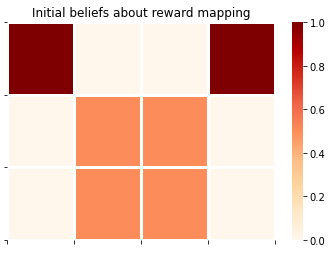

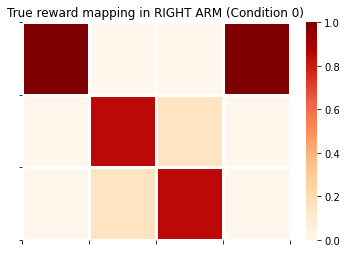

In [4]:
plot_likelihood(A_gm[1][:,:,0],'Initial beliefs about reward mapping')
plot_likelihood(A_gp[1][:,:,0],'True reward mapping in RIGHT ARM (Condition 0)')

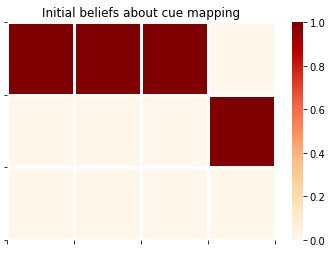

In [5]:
plot_likelihood(A_gm[2][:,:,0],'Initial beliefs about cue mapping')

In [6]:
B_gm = copy.deepcopy(B_gp)

In [7]:
controllable_indices = [0] # this is a list of the indices of the hidden state factors that are controllable
learnable_modalities = [1] # this is a list of the modalities that you want to be learn-able 

In [8]:
agent = Agent(A=A_gm,pA=pA,B=B_gm,
              control_fac_idx=controllable_indices,
              modalities_to_learn=learnable_modalities,
              lr_pA = 0.25,
              use_param_info_gain=True)

In [9]:
agent.D[0] = utils.onehot(0, agent.num_states[0])

In [10]:
agent.C[1][1] = 2.0
agent.C[1][2] = -2.0

In [11]:
T = 1000 # number of timesteps

obs = env.reset() # reset the environment and get an initial observation

# these are useful for displaying read-outs during the loop over time
reward_conditions = ["Right Arm Better", "Left arm Better"]
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION']
reward_observations = ['No reward','Reward!','Loss!']
cue_observations = ['Null','Cue Right','Cue Left']
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))

pA_history = []

all_actions = np.zeros((T, 2))
for t in range(T):
    
    qx = agent.infer_states(obs)

    q_pi, efe = agent.infer_policies()

    action = agent.sample_action()

    pA_t = agent.update_A(obs)
    pA_history.append(pA_t)
    
    msg = """[Step {}] Action: [Move to {}]"""
    print(msg.format(t, location_observations[int(action[0])]))

    obs = env.step(action)

    all_actions[t,:] = action

    msg = """[Step {}] Observation: [{},  {}, {}]"""
    print(msg.format(t, location_observations[int(obs[0])], reward_observations[int(obs[1])], cue_observations[int(obs[2])]))

 === Starting experiment === 
 Reward condition: Left arm Better, Observation: [CENTER, No reward, Null]
[Step 0] Action: [Move to CUE LOCATION]
[Step 0] Observation: [CUE LOCATION,  No reward, Cue Left]
[Step 1] Action: [Move to RIGHT ARM]
[Step 1] Observation: [RIGHT ARM,  Loss!, Null]
[Step 2] Action: [Move to RIGHT ARM]
[Step 2] Observation: [RIGHT ARM,  Loss!, Null]
[Step 3] Action: [Move to LEFT ARM]
[Step 3] Observation: [LEFT ARM,  Reward!, Null]
[Step 4] Action: [Move to LEFT ARM]
[Step 4] Observation: [LEFT ARM,  Reward!, Null]
[Step 5] Action: [Move to LEFT ARM]
[Step 5] Observation: [LEFT ARM,  Reward!, Null]
[Step 6] Action: [Move to LEFT ARM]
[Step 6] Observation: [LEFT ARM,  Loss!, Null]
[Step 7] Action: [Move to LEFT ARM]
[Step 7] Observation: [LEFT ARM,  Reward!, Null]
[Step 8] Action: [Move to LEFT ARM]
[Step 8] Observation: [LEFT ARM,  Reward!, Null]
[Step 9] Action: [Move to LEFT ARM]
[Step 9] Observation: [LEFT ARM,  Reward!, Null]
[Step 10] Action: [Move to LEFT A

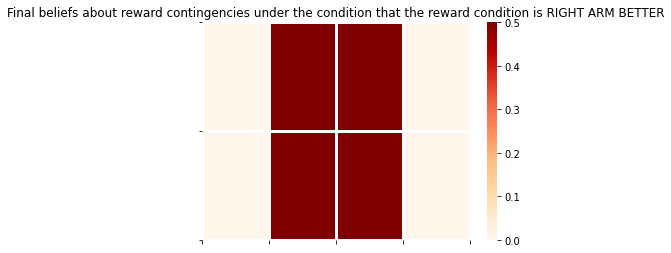

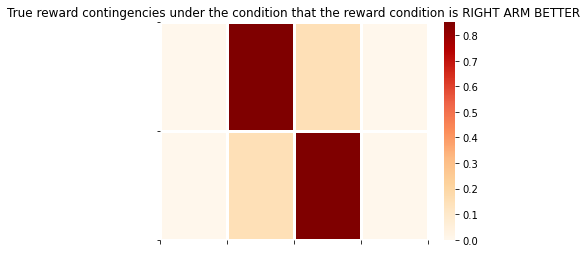

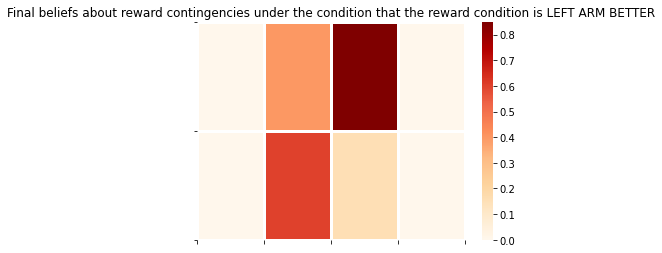

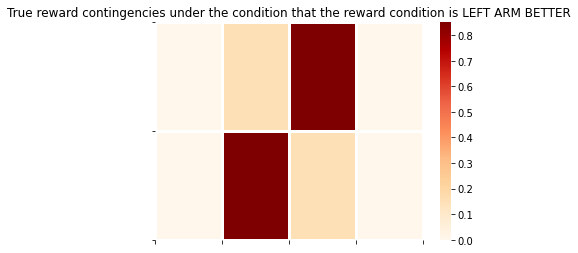

In [12]:
plot_likelihood(agent.A[1][1:,:,0],'Final beliefs about reward contingencies under the condition that the reward condition is RIGHT ARM BETTER')
plot_likelihood(A_gp[1][1:,:,0],'True reward contingencies under the condition that the reward condition is RIGHT ARM BETTER')

plot_likelihood(agent.A[1][1:,:,1],'Final beliefs about reward contingencies under the condition that the reward condition is LEFT ARM BETTER')
plot_likelihood(A_gp[1][1:,:,1],'True reward contingencies under the condition that the reward condition is LEFT ARM BETTER')


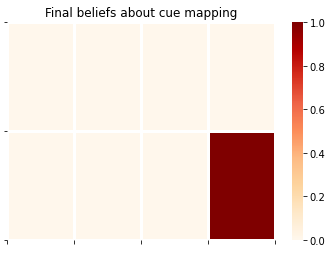

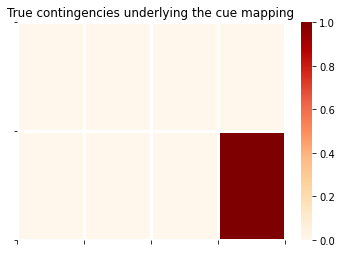

In [13]:
plot_likelihood(agent.A[2][1:,:,1],'Final beliefs about cue mapping')
plot_likelihood(A_gp[2][1:,:,1],'True contingencies underlying the cue mapping')